<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module5/M5_2/1_PaperRecycling_ReductionFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Problems: Reduction in Flow (Paper Recycling)
**OPIM 5641: Business Decision Modeling - University of Connecticut**

In this notebook, we will see that when $\text{DEMAND} \gt \text{SUPPLY}$, we must include an *'virtual'* supply node to satisfy the demand. Network problem is framed as a balance equation (similar to a 'bathtub problem' with inputs and outputs).

Please refer to Powell Chapter 10 for more details.

------------------------------------------------------------------------


## Yields as Reductions in Flow
One common type of yield phenomenon involves technologies that produce waste (from raw materials to finished product). When
wood is cut, shaped, and sanded in a manufacturing process, the amount of usable wood
that exits the process is less than the amount that entered. When metal enters a process
that involves grinding, drilling, and polishing, the same is true of the amount of metal at the
end of the process compared to the amount at the start. This type of reduction in the
amount of a flow is called **process yield**.

In [ ]:
pip install pyomo

     |████████████████████████████████| 9.4MB 2.5MB/s 
     |████████████████████████████████| 256kB 41.4MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 163kB 47.6MB/s 


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

import pyomo.environ as pyomo

Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 144618 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to unpack .../4-coinor-libcbc3_2.9.9+repack1-1_amd64.deb ...
Unpacking coinor-libcbc3 (2.9.9+repack1-1) ...
Selecting p

In [ ]:
from __future__ import division
from pyomo.environ import *

# Planning Recycling Operations

The Ligon Paper Company specializes in paper recycling. The company owns several facilities that
obtain paper from commercial or municipal sources, and they produce paper for a variety of markets
where customers are looking for recycled content.
Ligon Paper collects three types of input, which they classify as White Paper, Mixed Paper, and
Newsprint. Applying various processes, they produce three products: high-quality Office Paper,
lower-quality Catalog Paper, and napkin-grade Tan Stock.
One of the processes at Ligon Paper takes White Paper and converts it to Office Paper. For
each ton of White Paper input, the process generates 0.85 ton of Office Paper. Alternatively, a ton of
White Paper can be converted to Catalog Paper; here the yield is 0.90 ton. Thirdly, White Paper can
be converted to Tan Stock, with a yield of 95 percent. For the other types of input, different yields
apply, and it is not possible to convert Newsprint to Office Paper. The following table gives a
complete set of yield factors, stated as percentages:

. | Office | Catalog | Tan Stock
--- | --- | --- | --- 
White Paper | 85% | 90% | 95%
Mixed Paper | 60% | 70% | 80% 
Newsprint | -- | 65% | 60%





In the coming planning period, Ligon’s contracts with suppliers have generated 300 tons of
White Paper, 600 tons of Mixed Paper, and 400 tons of Newsprint. In existing markets, Ligon could
sell 150 tons of Office Paper at the market price of 25 dollars per ton, 750 tons of Catalog Paper at 20 dollars per ton,
and 550 tons of Tan Stock at 18 dollars per ton. The problem is to determine how much of each product to
produce.

In [ ]:
# let's check supply and demand

# supply (raw materials)
Supply = 300 + 600 + 400
Supply

# demand
Demand = 150 + 750 + 550
Demand

# difference
diff = Supply - Demand
diff


-150

**YIKES!** Even with a 1:1 recycling, we do not have enough raw materials to satisfy demand in the market. It's fine if there's more supply than demand - we can always hold onto materials until it's time to process - but the problem gets complicated when $\text{DEMAND} \gt \text{SUPPLY}$. 

We will see that we need to create a 'virtual' supply node that can help the problem balance out. Sometimes it will not be so obvious that you need a virtual supply node - if your model has an infeasible solution, this may be why!

# Model Formulation

Here is the the diagram for Ligon Paper (from the textbook):

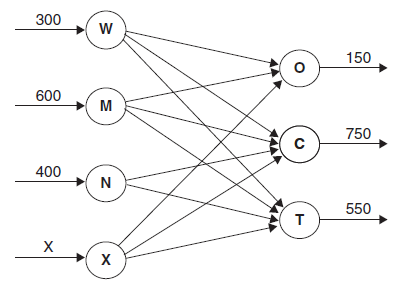

The next step is to convert the diagram into a linear programming model.

## Objective Function
$\max(\text{Gross Revenue}) = \\ 
\quad (25 \times WO) + (20 \times WC) + (18 \times WT) + \\
\quad (25 \times MO) + (20 \times MC) + (18 \times MT) + \\
\quad\quad\quad\quad\quad \quad \ \ \  (20 \times NC) + (18 \times NT) + \\
\quad \ \ (0 \times XO) +  \quad (0 \times XC) + \   (0 \times XT)$ 


**Thoughts on the objective function:** X variables are virtual supply satisfying real demand! Notice how there is no benefit to using virtual demand - it makes us NO REVENUE! Also notice how I've left out $NO$ because it DOESN'T EXIST! It's impossible to make newspaper out of office paper.

Now, we do not want the Gross Revenue - since our process as reduction in flow, the revenue contributions will also be scaled by the yields.

For examle, the coefficient for $WO$ becomes $25 \times 0.85 = 21.25$, the coefficient for $WC$ is $20 \times 0.9 = 18$. So we update the function.

Something like this...

$\max(\text{Net Revenue}) = \\ 
\quad (0.85 \times 25 \times WO) + (0.90 \times 20 \times WC) + (0.95 \times 18 \times WT) + \\
\quad (0.6 \times 25 \times MO) + (0.7 \times 20 \times MC) + (0.8 \times 18 \times MT) + \\
\quad\quad\quad\quad\quad \ \ \  (0.65 \times 20 \times NC) + (0.60 \times 18 \times NT) + \\
\quad\quad\quad 0 \times XO + \ 0 \times XC + \ 0 \times XT$ 


Which becomes...

$\max(\text{Net Revenue}) = \\ 
\quad (21.25 \times WO) + (18 \times WC) + (17.10 \times WT) + \\
\quad (15 \times MO) + (14 \times MC) + (14.40 \times MT) + \\
\quad\quad\quad\quad\quad \ \ \  (13 \times NC) + (10.80 \times NT) + \\
\quad \ \quad 0 \times XO + \ 0 \times XC + \ 0 \times XT$ 




## Supply Constraints
There are only 300 tons of white paper ($W$) available. We are trying to identify the product mix that will maximize profit. All the white paper we have as raw supply will be transformed into Office paper ($O$), Catalog Paper ($C$) or Tanstock ($T$).
* $WO + WC + WT = 300$
* $MO + MC + MT = 600$
* $NC + NT      = 400$

Do you notice how all the supply has POSITIVE SYMBOLS?

### Virtual Supply Constraints
We will use $X$ to denote our virtual supply, which would have went to Office paper ($O$), Catalog Paper ($C$) or Tanstock ($T$). X denotes the total virtual supply we would have available. It makes sense that this needs to balance to zero (outputs and inputs - we want to use ALL of our virutal supply to meet all of the actual demand that we can't satisfy.)
* $XO + XC + XT - X = 0$



## Demand Constraints 
We do not want to make more than the demand available for the product. We see that newsprint ($N$) can't be turned into white office paper, so we simply leave this out of the constraint. The actual supply we have along with the virtual supply ($X$) will help us satisfy demand.
* $-0.85 \times WO - 0.6 \times MO - XO = -150$
* $-0.9 \times WC - 0.7 \times MC - 0.65 \times NC - XC = -750$
* $-0.95 \times WT - 0.80 \times MT - 0.6 \times NT - XT = -550$

Do you notice how all of the demand has NEGATIVE SYMBOLS (coefficients)? This is so the math works out (INPUT + OUTPUT = 0). Everything has balanced perfectly.



# Implementation in Pyomo

In [ ]:
# specify the concrete model
model = ConcreteModel()

# decision variables (this allows us not to type domain=NonNegativeReals over and over again...)
model.x = Var([1,2,3,4,5,6,7,8,9,10,11,12], domain=NonNegativeReals)
WO = model.x[1] # white paper to office paper
WC = model.x[2] # white paper to cardstock
WT = model.x[3] # white paper to tanstock
MO = model.x[4] # mixed paper to office paper...
MC = model.x[5]
MT = model.x[6]
NC = model.x[7] # remember, no 'NO' because it's impossible to create!
NT = model.x[8]
XO = model.x[9] # virtual supply to make office paper (to meet unmet demand for office paper)
XC = model.x[10] # virtual supply to make card stock paper (to meet unmet demand for card stock paper)
XT = model.x[11]
X  = model.x[12] # total virtual supply to meet unmet demand

# define the objective function (the revenue amounts!)
model.OBJ = Objective(expr = 21.25*WO + 18*WC + 17.1*WT + 15*MO + 14*MC + 14.4*MT + 13*NC + 10.8*NT,sense=maximize)

# supply constraints - ALWAYS HAVE POSITIVE COEFFICIENTS!
model.Constraint1 = Constraint(expr = WO + WC + WT == 300)
model.Constraint2 = Constraint(expr = MO + MC + MT == 600)
model.Constraint3 = Constraint(expr = NC + NT == 400)

# virtual supply must satisfy virtual demand
model.Constraint4 = Constraint(expr = XO + XC + XT - X == 0)

# demand constraints - ALWAYS HAVE NEGATIVE COEFFICIENTS
model.Constraint5 = Constraint(expr = -0.85*WO - 0.6*MO - XO == -150) # demand for office paper
model.Constraint6 = Constraint(expr = -0.9*WC - 0.7*MC - 0.65*NC - XC == -750) # demand for card stock
model.Constraint7 = Constraint(expr = -0.95*WT - 0.80*MT - 0.6*NT - XT == -550) # demand for tan stock

In [ ]:
model.pprint()

1 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   12 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

1 Var Declarations
    x : Size=12, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :  None : False :  True : NonNegativeReals
          2 :     0 :  None :  None : False :  True : NonNegativeReals
          3 :     0 :  None :  None : False :  True : NonNegativeReals
          4 :     0 :  None :  None : False :  True : NonNegativeReals
          5 :     0 :  None :  None : False :  True : NonNegativeReals
          6 :     0 :  None :  None : False :  True : NonNegativeReals
          7 :     0 :  None :  None : False :  True : NonNegativeReals
          8 :     0 :  None :  None : False :  True : NonNegativeReals
          9 :     0 :  None :  None : False :  True : NonNegativeReals
         10 :     0 :  None :  None : False :  True 

In [ ]:
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19813.52941
  Upper bound: 19813.52941
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 13
  Number of nonzeros: 7
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number o

# Result

In [ ]:
print("Profit = ", value(model.OBJ()))

Profit =  19813.5294175


In [ ]:
print('\n', 'Flow from W ')
print('Flow from W to O:', model.x[1]())
print('Flow from W to C:', model.x[2]())
print('Flow from W to T:', model.x[3]())

print('\n', 'Flow from M ')
print('Flow from M to O:', model.x[4]())
print('Flow from M to C:', model.x[5]())
print('Flow from M to T:', model.x[6]())

print('\n', 'Flow from N ')
print('Flow from N to C:', model.x[7]())
print('Flow from N to T:', model.x[8]())

print('\n', 'Flow from X ')
print('Flow from X to O:', model.x[9]())
print('Flow from X to C:', model.x[10]())
print('Flow from X to T:', model.x[11]())

print('Flow from X:', model.x[12]())




 Flow from W 
Flow from W to O: 176.47059
Flow from W to C: 123.52941
Flow from W to T: 0.0

 Flow from M 
Flow from M to O: 0.0
Flow from M to C: 0.0
Flow from M to T: 600.0

 Flow from N 
Flow from N to C: 400.0
Flow from N to T: 0.0

 Flow from X 
Flow from X to O: 0.0
Flow from X to C: 378.82353
Flow from X to T: 70.0
Flow from X: 448.82353


# Analysis
White Paper should be processed into Office Paper and Catalog Paper; Mixed Paper should be processed into Tan Stock, and Newsprint should be processed into Catalog Paper. This production plan results in total revenue of $19,814. Thus, the yield-based model provides
Ligon Paper with a revenue-maximizing allocation of its supply (capacity).

In [ ]:
# how many tons of office paper did we make? we met all the demand
0.85*value(WO) + 0.6*value(MO)

150.0000015

In [ ]:
# how many tons of cardstock did we make? 371 tons of cardstock.
0.9*value(WC) + 0.7*value(MC) + 0.65*value(NC)

371.176469

In [ ]:
# and this is why the flow from X to C is 378 tons...
# we did not meet 378 tons of demand!
750 - (0.9*value(WC) + 0.7*value(MC) + 0.65*value(NC))

378.823531

In [ ]:
# students can work out the rest on their own...